In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
# Veri yükleme
train_df = pd.read_csv('PM_train.csv')
test_df = pd.read_csv('PM_test.csv')
truth_df = pd.read_csv('PM_truth.csv')

In [3]:
# Veri ön işleme
def preprocess_data(df):
    df = df.drop(['setting3', 's1', 's5', 's10', 's16', 's18', 's19'], axis=1)
    last_cycles = df.groupby('id')['cycle'].max().reset_index()
    last_cycles.columns = ['id', 'max_cycle']
    df = pd.merge(df, last_cycles, on='id', how='left')
    df['RUL'] = df['max_cycle'] - df['cycle']
    return df

train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

In [4]:
# Özellik seçimi
features = ['setting1', 'setting2', 'cycle'] + [f's{i}' for i in range(2, 22) if i not in [5, 10, 16, 18, 19]]

In [5]:
# Veri hazırlama fonksiyonu
def prepare_data(df, sequence_length=10):
    data = []
    labels = []
    for id in df['id'].unique():
        df_id = df[df['id'] == id]
        for i in range(len(df_id) - sequence_length + 1):
            data.append(df_id[features].iloc[i:i+sequence_length].values)
            labels.append(df_id['RUL'].iloc[i+sequence_length-1])
    return np.array(data), np.array(labels)

In [6]:
# Veriyi hazırla
X, y = prepare_data(train_df)

# Veriyi böl
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Veriyi ölçeklendir
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

In [8]:
# CNN modelini oluştur
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

C:\Users\Emirhan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Model eğitimi
history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
                    epochs=100, batch_size=32, verbose=1)

Epoch 1/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5065.3086 - mae: 51.2292 - val_loss: 1358.1954 - val_mae: 26.2909
Epoch 2/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1648.2706 - mae: 29.1272 - val_loss: 1306.8175 - val_mae: 26.5610
Epoch 3/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1527.4011 - mae: 27.9759 - val_loss: 1270.6376 - val_mae: 25.8361
Epoch 4/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1488.8550 - mae: 27.3559 - val_loss: 1262.8290 - val_mae: 24.1981
Epoch 5/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1478.6095 - mae: 27.1065 - val_loss: 1181.4701 - val_mae: 24.6028
Epoch 6/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1364.7885 - mae: 26.0411 - val_loss: 1221.4353 - val_mae: 23.5789
Epoch 7/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1403.3317 - mae: 26.4799 - val_loss: 1175.5137 - val_mae: 24.9828
Epoch 8/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1340.5795 - mae: 25.9688 - val_loss: 1147.2642 - v

In [10]:
# Test verisi için tahminler
X_test, y_test = prepare_data(test_df)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
test_predictions = model.predict(X_test_scaled).flatten()

382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [11]:
# Her motor için son tahmin
final_predictions = test_df.groupby('id').last().reset_index()
final_predictions['RUL_predicted'] = test_predictions[-len(final_predictions):]
final_predictions = pd.merge(final_predictions, truth_df, on='id', how='left')

In [13]:
# Truth verisini kontrol et ve doğru sütun adını bul
print("Truth verisi sütunları:", truth_df.columns)

# Truth verisindeki gerçek RUL değerlerini kullan
if 'RUL' in truth_df.columns:
    true_rul_column = 'RUL'
elif 'cycle' in truth_df.columns:
    true_rul_column = 'cycle'
elif len(truth_df.columns) == 2:  # Eğer sadece iki sütun varsa
    true_rul_column = truth_df.columns[1]  # İkinci sütunu kullan (ilki muhtemelen 'id')
else:
    raise ValueError("Truth verisinde uygun RUL veya cycle sütunu bulunamadı.")

print(f"Kullanılan true_rul_column: {true_rul_column}")

Truth verisi sütunları: Index(['id', 'cycle'], dtype='object')
Kullanılan true_rul_column: cycle


In [14]:
# Eğer true_rul_column final_predictions'da yoksa, truth_df'den ekleyelim
if true_rul_column not in final_predictions.columns:
    final_predictions = pd.merge(final_predictions, truth_df, on='id', how='left')

# Veri tipini float'a çevir
final_predictions[true_rul_column] = final_predictions[true_rul_column].astype(float)

In [15]:
# Performans değerlendirme
mse = mean_squared_error(final_predictions[true_rul_column], final_predictions['RUL_predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(final_predictions[true_rul_column], final_predictions['RUL_predicted'])

print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'R-squared Score: {r2:.4f}')

Root Mean Squared Error: 53.9999
R-squared Score: -0.6886


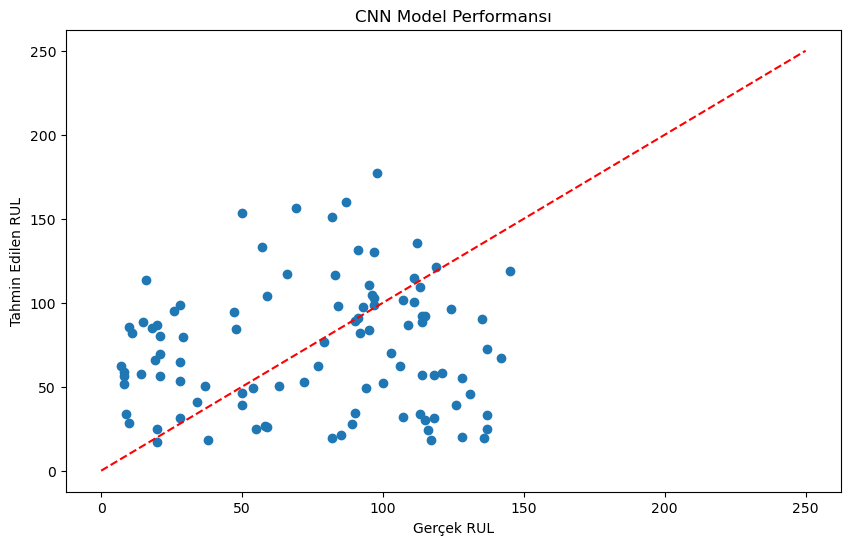

In [16]:
# Tahmin vs Gerçek değer grafiği
plt.figure(figsize=(10, 6))
plt.scatter(final_predictions[true_rul_column], final_predictions['RUL_predicted'])
plt.plot([0, 250], [0, 250], 'r--')
plt.xlabel('Gerçek RUL')
plt.ylabel('Tahmin Edilen RUL')
plt.title('CNN Model Performansı')
plt.show()

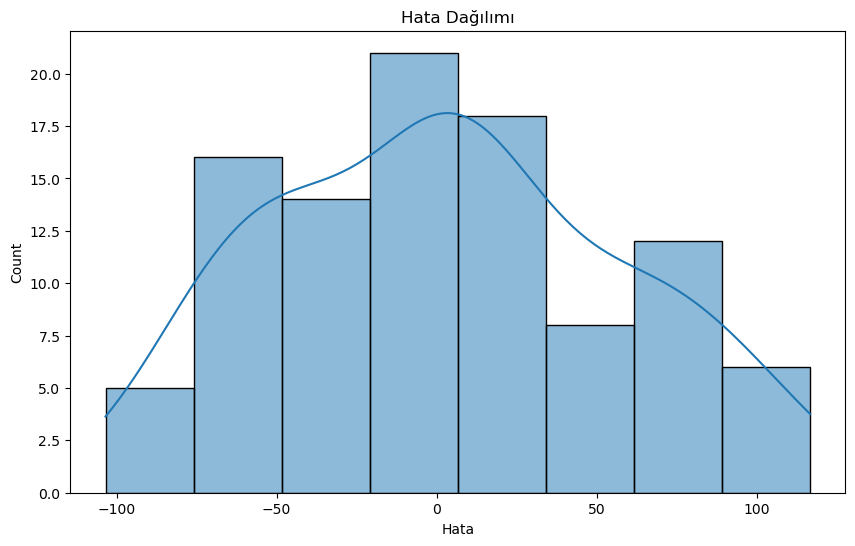

In [17]:
# Hata analizi
final_predictions['error'] = final_predictions[true_rul_column] - final_predictions['RUL_predicted']
plt.figure(figsize=(10, 6))
sns.histplot(final_predictions['error'], kde=True)
plt.title('Hata Dağılımı')
plt.xlabel('Hata')
plt.show()

In [19]:
# Bakım tahminleri
def format_maintenance_prediction(row):
    id = row['id']
    predicted_rul = row['RUL_predicted']
    hours = round(predicted_rul)
    if hours <= 0:
        return f"Motor ID {id}: ACİL BAKIM GEREKLİ! Tahmini kalan ömür süresi aşılmış."
    elif hours < 50:
        return f"Motor ID {id}: DİKKAT! Yakın zamanda bakım gerekli. Tahmini kalan süre: {hours} saat."
    elif hours < 100:
        return f"Motor ID {id}: Bakım planlanmalı. Tahmini kalan süre: {hours} saat."
    else:
        return f"Motor ID {id}: İyi durumda. Tahmini kalan süre: {hours} saat."

final_predictions['maintenance_message'] = final_predictions.apply(format_maintenance_prediction, axis=1)

print("\nBakım Tahminleri:")
for message in final_predictions['maintenance_message']:
    print(message)


Bakım Tahminleri:
Motor ID 1: İyi durumda. Tahmini kalan süre: 136 saat.
Motor ID 2: İyi durumda. Tahmini kalan süre: 177 saat.
Motor ID 3: İyi durumda. Tahmini kalan süre: 156 saat.
Motor ID 4: İyi durumda. Tahmini kalan süre: 151 saat.
Motor ID 5: İyi durumda. Tahmini kalan süre: 132 saat.
Motor ID 6: Bakım planlanmalı. Tahmini kalan süre: 97 saat.
Motor ID 7: Bakım planlanmalı. Tahmini kalan süre: 91 saat.
Motor ID 8: Bakım planlanmalı. Tahmini kalan süre: 84 saat.
Motor ID 9: İyi durumda. Tahmini kalan süre: 100 saat.
Motor ID 10: İyi durumda. Tahmini kalan süre: 104 saat.
Motor ID 11: Bakım planlanmalı. Tahmini kalan süre: 99 saat.
Motor ID 12: Bakım planlanmalı. Tahmini kalan süre: 96 saat.
Motor ID 13: İyi durumda. Tahmini kalan süre: 110 saat.
Motor ID 14: İyi durumda. Tahmini kalan süre: 101 saat.
Motor ID 15: İyi durumda. Tahmini kalan süre: 116 saat.
Motor ID 16: Bakım planlanmalı. Tahmini kalan süre: 98 saat.
Motor ID 17: İyi durumda. Tahmini kalan süre: 153 saat.
Motor ID

In [20]:
# Accuracy hesaplama
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [21]:
def calculate_accuracy(y_true, y_pred, threshold=100):
    y_true_class = (y_true <= threshold).astype(int)
    y_pred_class = (y_pred <= threshold).astype(int)
    accuracy = accuracy_score(y_true_class, y_pred_class)
    conf_matrix = confusion_matrix(y_true_class, y_pred_class)
    class_report = classification_report(y_true_class, y_pred_class)
    return accuracy, conf_matrix, class_report

y_true = final_predictions[true_rul_column].values
y_pred = final_predictions['RUL_predicted'].values

accuracy, conf_matrix, class_report = calculate_accuracy(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Accuracy: 0.5900

Confusion Matrix:
[[ 7 26]
 [15 52]]

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.21      0.25        33
           1       0.67      0.78      0.72        67

    accuracy                           0.59       100
   macro avg       0.49      0.49      0.49       100
weighted avg       0.55      0.59      0.56       100



In [22]:
# Farklı eşik değerleri için accuracy hesapla
thresholds = [50, 100, 150, 200]
for threshold in thresholds:
    acc, _, _ = calculate_accuracy(y_true, y_pred, threshold)
    print(f"Accuracy (threshold={threshold}): {acc:.4f}")

# Sonuçları kaydet
final_predictions.to_csv('cnn_predictions.csv', index=False)

Accuracy (threshold=50): 0.5500
Accuracy (threshold=100): 0.5900
Accuracy (threshold=150): 0.9500
Accuracy (threshold=200): 1.0000


C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
